In [ ]:
import os
import cv2
import heapq
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import shannon_entropy

In [2]:
carpetas_img = './chest_xray/train'

subcarpetas = [carpetas.path for carpetas in os.scandir(carpetas_img) if carpetas.is_dir()]

carpeta_pneumonia = subcarpetas[0]
carpeta_normal = subcarpetas[1]

img_pneumonia_alto = []
img_pneumonia_ancho = []

img_normal_alto = []
img_normal_ancho = []

for img in os.scandir(carpeta_pneumonia):
    if img.name.endswith(('.jpeg', '.jpg', '.png')):
        img_pneumonia_alto.append(cv2.imread(img.path).shape[0])
        img_pneumonia_ancho.append(cv2.imread(img.path).shape[1])

for img in os.scandir(carpeta_normal):
    if img.name.endswith(('.jpeg', '.jpg', '.png')):
        img_normal_alto.append(cv2.imread(img.path).shape[0])
        img_normal_ancho.append(cv2.imread(img.path).shape[1])


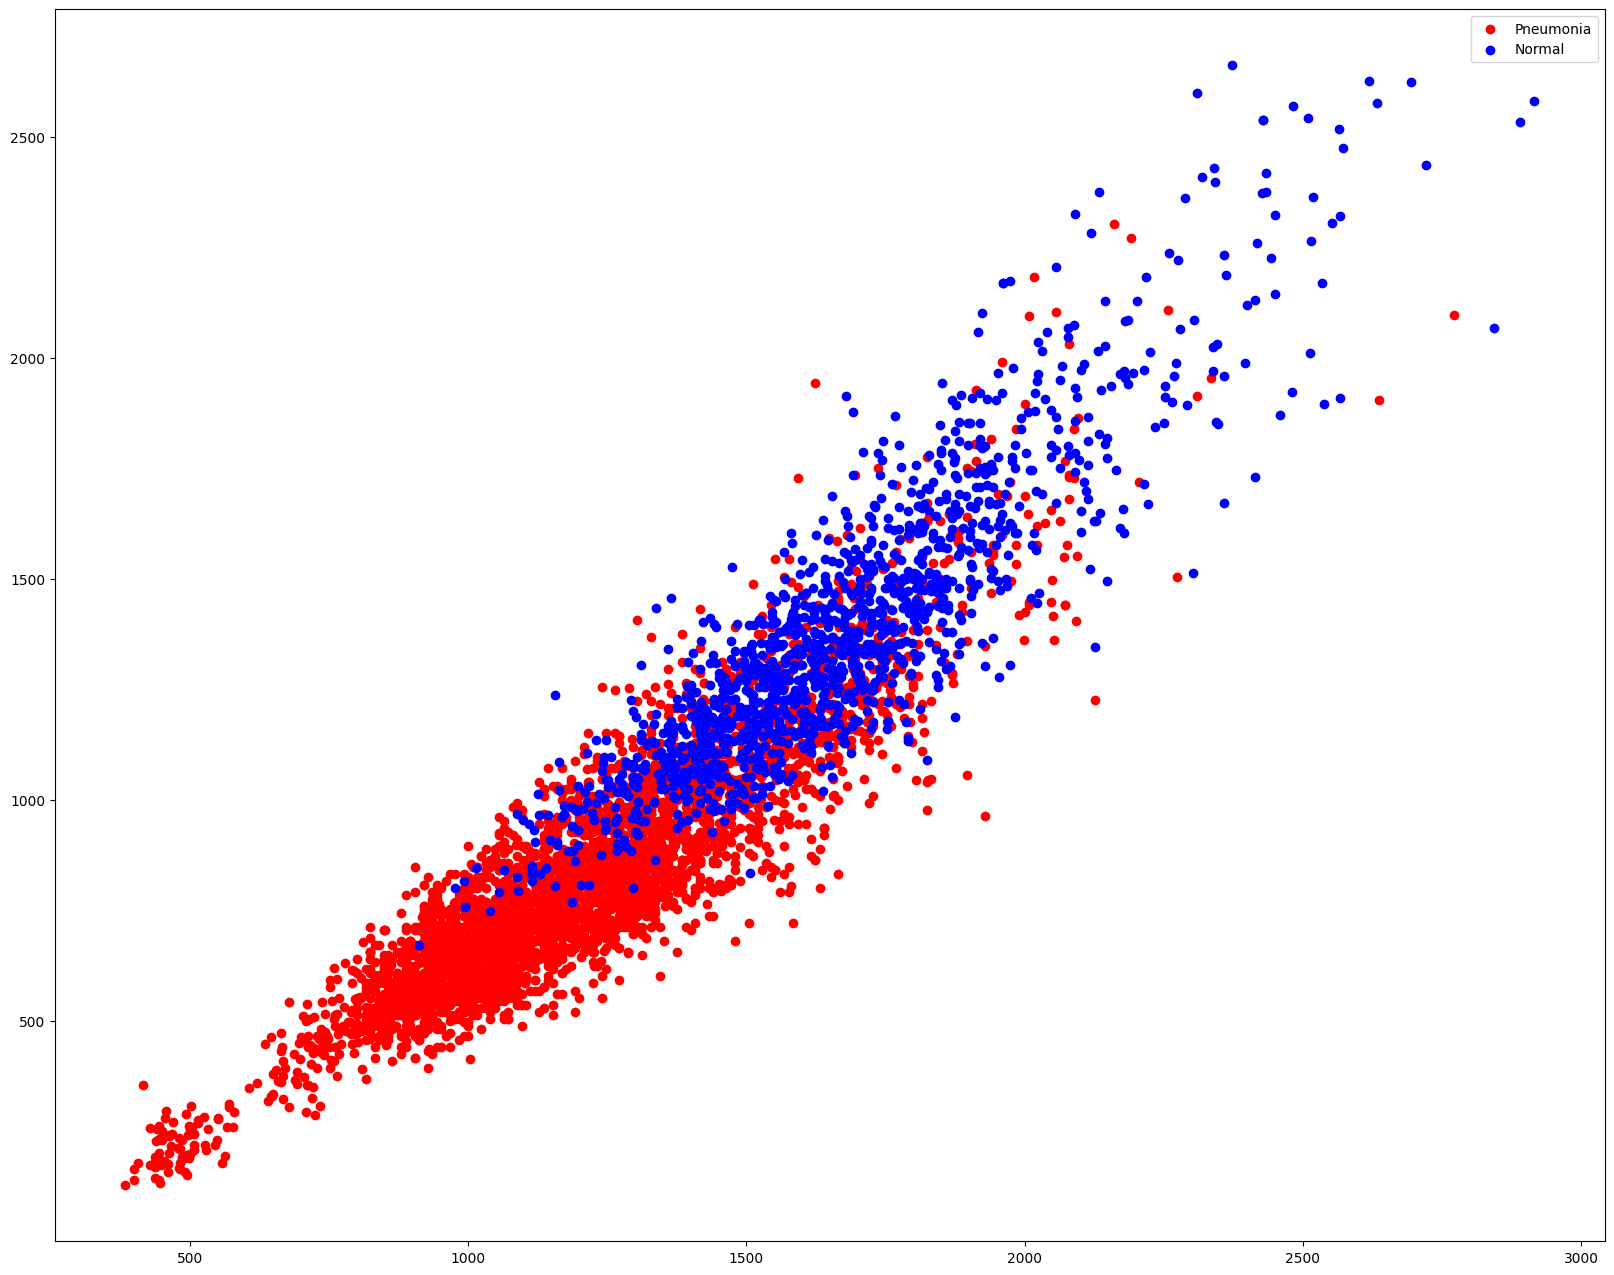

In [3]:
plt.figure(figsize=(20, 16))
plt.scatter(img_pneumonia_ancho, img_pneumonia_alto, color='red', label='Pneumonia')
plt.scatter(img_normal_ancho, img_normal_alto, color='blue', label='Normal')
plt.legend()
plt.show()


--- PNEUMONIA ---
224×224: ΔH=0.0006 bits, ΔL=0.0007 bits
192×192: ΔH=0.0015 bits, ΔL=0.0017 bits
160×160: ΔH=0.0031 bits, ΔL=0.0034 bits
128×128: ΔH=0.0066 bits, ΔL=0.0071 bits

--- NORMAL ---
224×224: ΔH=0.0009 bits, ΔL=0.0012 bits
192×192: ΔH=0.0025 bits, ΔL=0.0029 bits
160×160: ΔH=0.0049 bits, ΔL=0.0057 bits
128×128: ΔH=0.0090 bits, ΔL=0.0103 bits


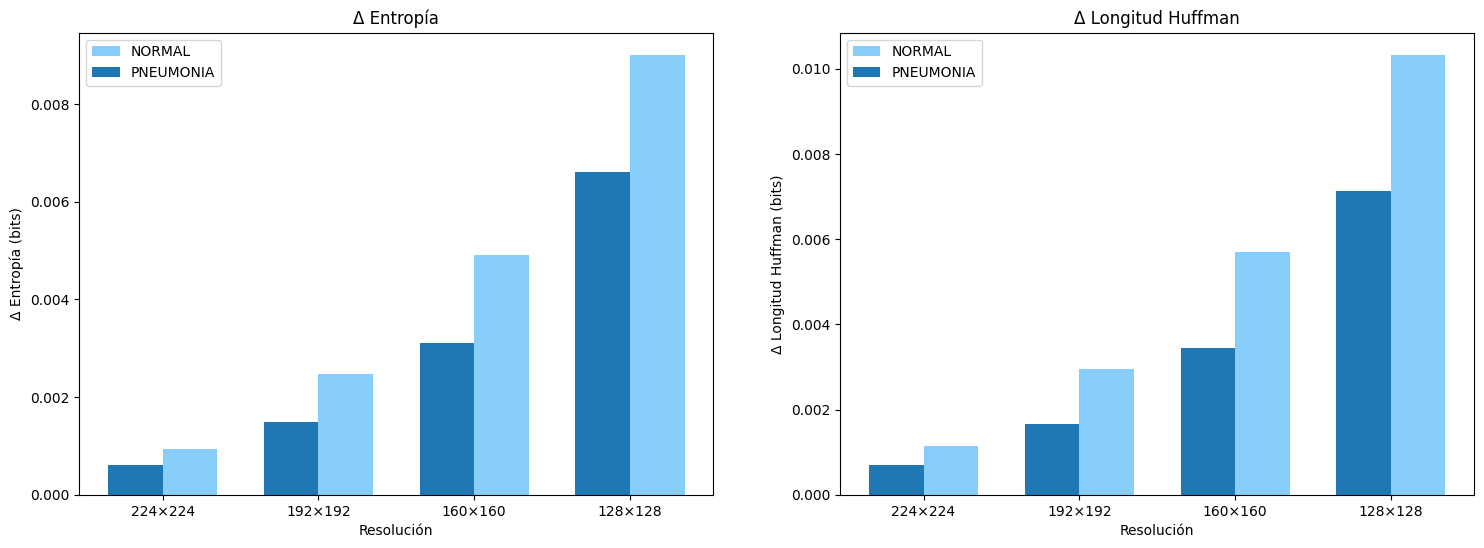

In [ ]:
# Funciones

def entropia(img):
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return shannon_entropy(img)

def longitud_huffman(img):
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([img], [0], None, [256], [0, 256]).flatten()
    p = hist[hist > 0] / hist.sum()
    heap = list(p); heapq.heapify(heap)
    total = 0
    while len(heap) > 1:
        a = heapq.heappop(heap)
        b = heapq.heappop(heap)
        s = a + b
        total += s
        heapq.heappush(heap, s)
    return total  # L promedio

def reescala(img, size, interp):
    return cv2.resize(img, size, interpolation=interp)

# Configuración
ref_size = (256, 256)
resoluciones = {
    "224×224": (224, 224),
    "192×192": (192, 192),
    "160×160": (160, 160),
    "128×128": (128, 128),
}

carpetas = {
    "PNEUMONIA": "./chest_xray/train/PNEUMONIA",
    "NORMAL"   : "./chest_xray/train/NORMAL",
}

# Métricas a acumular
metricas = ["H256", "Hr", "ΔH", "L256", "Lr", "ΔL"]
resultados = {
    clase: {tag: {m: [] for m in metricas} for tag in resoluciones}
    for clase in carpetas
}

# Bucle de procesamiento
for clase, path in carpetas.items():
    for entry in os.scandir(path):
        if not entry.name.lower().endswith(('.jpg','.jpeg','.png')):
            continue
        img_orig = cv2.imread(entry.path)
        if img_orig is None:
            continue

        # Fuente de referencia 256×256 (INTER_AREA)
        X256 = reescala(img_orig, ref_size, cv2.INTER_NEAREST)
        H256 = entropia(X256)
        L256 = longitud_huffman(X256)

        for tag, size in resoluciones.items():
            Yr = reescala(img_orig, size, cv2.INTER_NEAREST)
            Hr = entropia(Yr)
            Lr = longitud_huffman(Yr)

            resultados[clase][tag]["H256"].append(H256)
            resultados[clase][tag]["Hr"].append(Hr)
            resultados[clase][tag]["ΔH"].append(H256 - Hr)
            resultados[clase][tag]["L256"].append(L256)
            resultados[clase][tag]["Lr"].append(Lr)
            resultados[clase][tag]["ΔL"].append(L256 - Lr)

# Cálculo de promedios
prom = {
    clase: {
        tag: {m: np.mean(resultados[clase][tag][m]) for m in metricas}
        for tag in resoluciones
    }
    for clase in carpetas
}

# Impresión
for clase in carpetas:
    print(f"\n--- {clase} ---")
    for tag, vals in prom[clase].items():
        print(f"{tag}: ΔH={vals['ΔH']:.4f} bits, ΔL={vals['ΔL']:.4f} bits")

# Gráficas
tags = list(resoluciones.keys())
x = np.arange(len(tags))
width = 0.35

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.bar(x + width/2, [prom["NORMAL"][t]["ΔH"] for t in tags], width, color="#87cefa", label="NORMAL")
plt.bar(x - width/2, [prom["PNEUMONIA"][t]["ΔH"] for t in tags], width, color="#1f77b4", label="PNEUMONIA")
plt.xticks(x, tags)
plt.title("Δ Entropía")
plt.xlabel("Resolución")
plt.ylabel("Δ Entropía (bits)")
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(x + width/2, [prom["NORMAL"][t]["ΔL"] for t in tags], width, color="#87cefa", label="NORMAL")
plt.bar(x - width/2, [prom["PNEUMONIA"][t]["ΔL"] for t in tags], width, color="#1f77b4", label="PNEUMONIA")
plt.xticks(x, tags)
plt.title("Δ Longitud Huffman")
plt.xlabel("Resolución")
plt.ylabel("Δ Longitud Huffman (bits)")
plt.legend()
plt.show()